<ipython-input-3-6080952345cc>:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train_processed.csv', parse_dates=['Date'], index_col='Date')
<ipython-input-3-6080952345cc>:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('test_processed.csv', parse_dates=['Date'], index_col='Date')


ADF Statistic: -7.17670619209591
p-value: 2.715438503434505e-10
Critial Values:
   1%, -3.5352168748293127
Critial Values:
   5%, -2.9071540828402367
Critial Values:
   10%, -2.5911025443786984


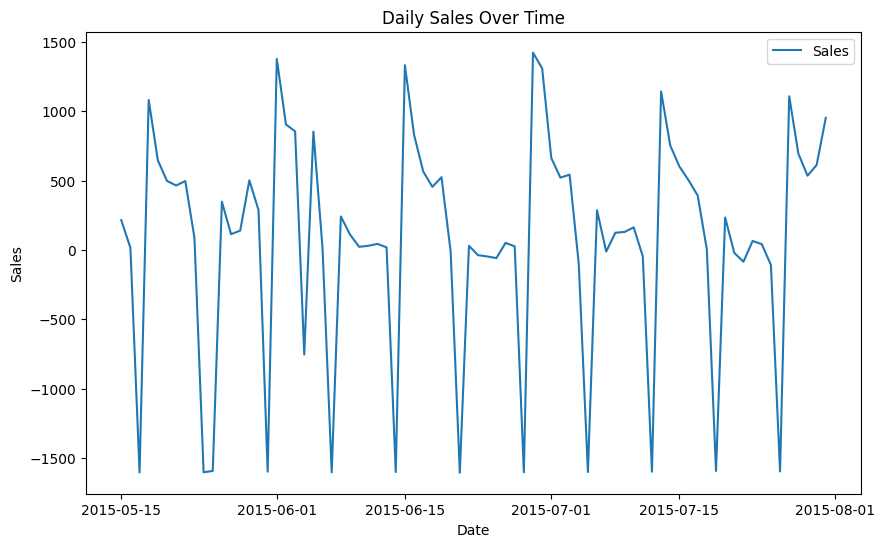

ADF Statistic: -12.16600250966545
p-value: 1.4568453758273465e-22
Critial Values:
   1%, -3.53692771987915
Critial Values:
   5%, -2.907887369384766
Critial Values:
   10%, -2.591493291015625


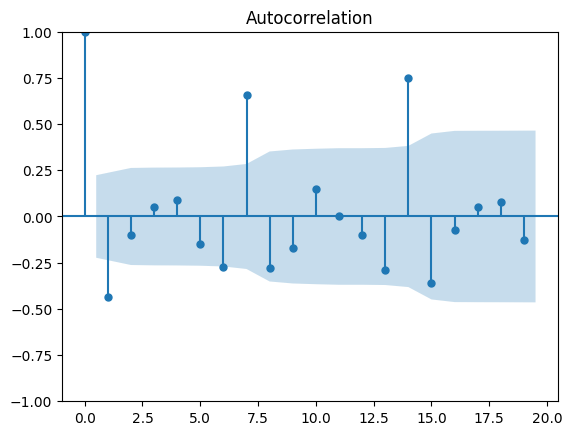

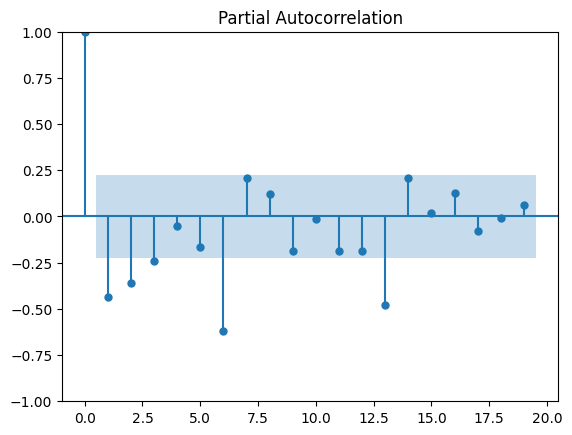

Epoch 1/20
2/2 [==============================] - 5s 921ms/step - loss: 0.2523 - val_loss: 0.1681
Epoch 2/20
2/2 [==============================] - 0s 54ms/step - loss: 0.2291 - val_loss: 0.1651
Epoch 3/20
2/2 [==============================] - 0s 56ms/step - loss: 0.2222 - val_loss: 0.1805
Epoch 4/20
2/2 [==============================] - 0s 56ms/step - loss: 0.2422 - val_loss: 0.1897
Epoch 5/20
2/2 [==============================] - 0s 53ms/step - loss: 0.2378 - val_loss: 0.1779
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 0.2288 - val_loss: 0.1687
Epoch 7/20
2/2 [==============================] - 0s 58ms/step - loss: 0.2214 - val_loss: 0.1647
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 0.2315 - val_loss: 0.1636
Epoch 9/20
2/2 [==============================] - 0s 53ms/step - loss: 0.2249 - val_loss: 0.1634
Epoch 10/20
2/2 [==============================] - 0s 54ms/step - loss: 0.2239 - val_loss: 0.1633
Epoch 11/20
2/2 [===========

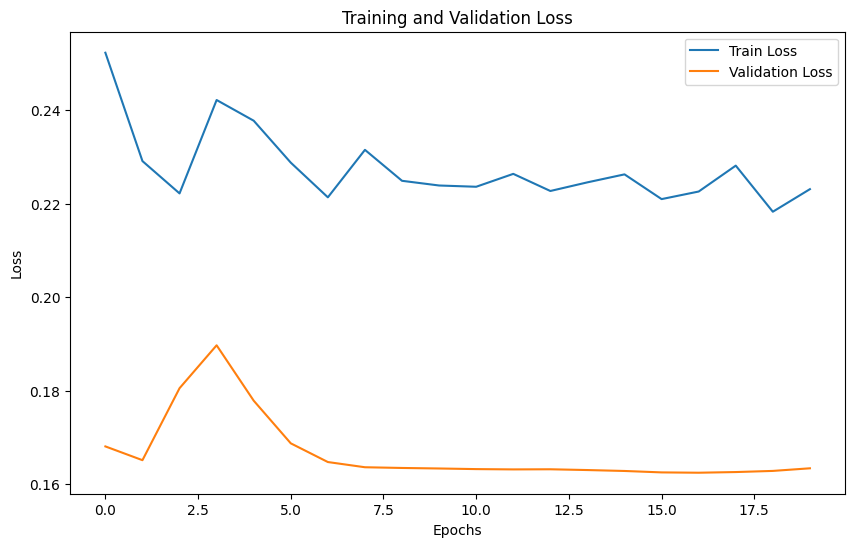

1/1 [==============================] - 1s 819ms/step
Validation RMSE: 993.2951839112417


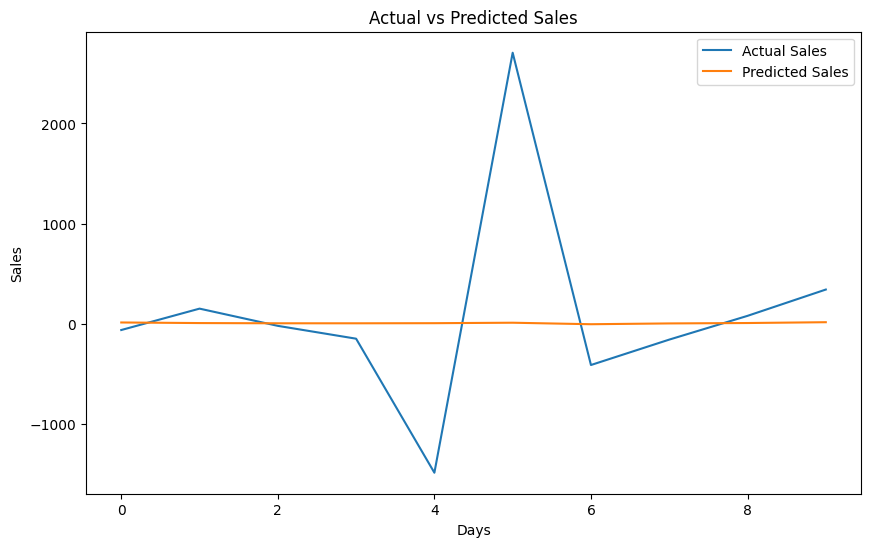

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load the data
train = pd.read_csv('train_processed.csv', parse_dates=['Date'], index_col='Date')
test = pd.read_csv('test_processed.csv', parse_dates=['Date'], index_col='Date')

# Step 1: Isolate the sales data into a time series format
sales_data = train[['Sales']]
sales_data = sales_data.resample('D').sum()  # Resample to daily sales

# Step 2: Check whether your time series data is stationary
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

check_stationarity(sales_data['Sales'])

# Plot the sales data to visualize trends
plt.figure(figsize=(10, 6))
plt.plot(sales_data, label='Sales')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 3: Difference your time series data if necessary
sales_data_diff = sales_data.diff().dropna()

check_stationarity(sales_data_diff['Sales'])

# Step 4: Check for autocorrelation and partial autocorrelation
plot_acf(sales_data_diff)
plt.show()
plot_pacf(sales_data_diff)
plt.show()

# Step 5: Transform the time series data into supervised learning data using a sliding window
def create_dataset(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Define window size
window_size = 30

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(sales_data_diff)

# Create supervised data
X, y = create_dataset(scaled_data, window_size)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]

# Split into train and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Step 6: Build and train an LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 7: Evaluate the model
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f'Validation RMSE: {rmse}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Save the model
model.save('../data/models/lstm_model.h5')